# Is seasonality a good predictor of implied volatility?

The goal of this project is to test whether or not seasonality is a good predictor of implied volatility in CBOT grain products. First, we will define 'seasonality' as a numerical value to describe a date's relative position within a year. Then we will try four different models to see which is the best option to model implied vol going forward.

### Defining Seasonality and Implementing Models

We will use the following models for this project:

#### 1. Sine Wave / Linear Seasonality
#### 2. Polynomial Curve Fit
#### 3. Cubic Spline Interpolation
#### 4. ARIMA Model

### Testing Seasonality functions

First, we need to define seasonality. We're going to create a few "seasonality" parameters using either sinusoidal functions or a linear interpretation. We've selected July 2nd as peak seasonality for the initial testing. The initial operating theory is that the best model for seasonality of implied volatility is a sine curve. 

In this model, the relative distance from peak seasonlaity is what matters, not the date within a calendar year. For example, if July 1st is (on average) the maximum implied volatility during the year, both April 1st and October 1st should have similar implied vol averages and thus "seasonality" as we have defined it.

In [2]:
#import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import timeit
import scipy as sp

from scipy.interpolate import interp1d
from scipy.interpolate import LSQUnivariateSpline
from scipy.interpolate import UnivariateSpline

from scipy.optimize import curve_fit

## 1. Sine Wave / Linear Seasonality

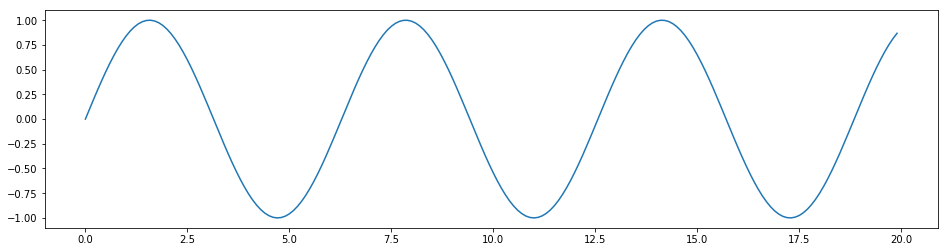

Sine Wave Max Amplitude:  1.0
Sine Wave Min Amplitude: -1.0


In [12]:
#plot basic sine wave for expected seasonality

x = np.arange(0,20,.1)
y = np.sin(x)
plt.figure(figsize=(16,4))
plt.plot(x,y)
plt.show()

# double check function for max/min amplitude

print("Sine Wave Max Amplitude: ", np.sin(np.pi/2))
print("Sine Wave Min Amplitude:", np.sin(-np.pi/2))

### Below we establish our three seasonality functions

In a given run through this sheet, only one seasonality function should be enabled. Disable and enable each function by highlighting that function's code (starting with `def date_season...`) and press `CTRL + /`

1. Sine Wave Seasonality: Uses sine wave function from NumPy and establishes a stated min and max seasonality
2. Cosine Seasonality: Uses the cosine function from NumPy, defines a period as one year and sets only a max seasonality
3. Linear Seasonality: Uses a linear interpretation of seasonality, this avoids clustering of data around -1.0 & +1.0 seasonality, which is prevelant with sinusoidal functions

In [15]:
# SINE SEASONALITY FUNCTION 
 
# def date_season(date):
#     """
#     computes seasonality parameter.  date should be pd.datetime
#     """
#     year = date.year
#     min_season = pd.datetime(year,1,1)
#     max_season = pd.datetime(year,7,2)
#     dif = abs(max_season - date)
#     dif_days = dif.days
#     x = (((max_season - min_season).days) - dif.days * 2) / (max_season - min_season).days
#     seasonality = np.sin(x * (np.pi) / 2)
#     return(seasonality)

In [16]:
# COSINE SEASONALITY FUNCTION

# def date_season(date):
#     """
#     computes seasonality parameter.  date should be pd.datetime
#     """
#     year = date.year
#     max_season = pd.datetime(year,7,2) 
#     dif = date - max_season
#     dif_days = dif.days
#     day_count = (pd.datetime(year + 1, 1, 1) - pd.datetime(year, 1, 1)).days
#     x = (dif_days / (day_count)) * (2 * np.pi)
#     seasonality = np.cos(x)
#     return(seasonality)

In [20]:
# LINEAR SEASONALITY FUNCTION

def date_season(date):
    """
    computes seasonality parameter.  date should be pd.datetime
    """
    year = date.year
    max_season = pd.datetime(year,7,2) 
    dif = date - max_season
    dif_days = dif.days
    day_count = (pd.datetime(year + 1, 1, 1) - pd.datetime(year, 1, 1)).days
    seasonality = 1 - (abs(dif_days) / day_count) * 2
    return(seasonality)

In [25]:
# creates a range of dates to test mapping of the seasonality function

start = dt.date(2017,1,1)
end = dt.date(2019,12,31)
df = pd.DataFrame({'Date': pd.date_range(start, end, freq="D")})

# map seasonality parameter to relevant dates
df['Seasonality'] = df.applymap(lambda x: date_season(x))

# check to see if seasonality parameter is mapping properly
df.head()

,Date,Seasonality
0,2017-01-01,0.002740
1,2017-01-02,0.008219
2,2017-01-03,0.013699
3,2017-01-04,0.019178
4,2017-01-05,0.024658


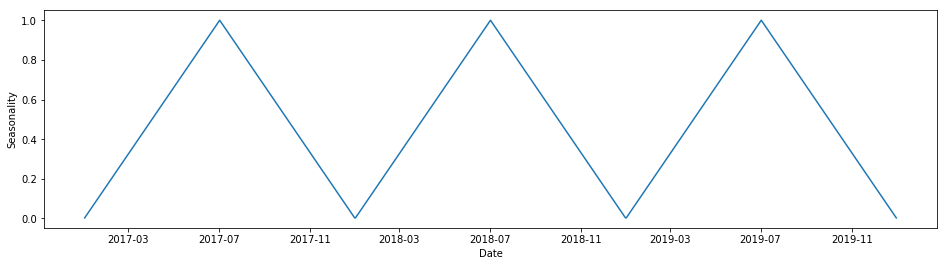

In [30]:
# checks plot of seasonality vs date. Should be a sine wave or triangular pattern based on which seasonality function is used

plt.figure(figsize=(16,4))
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.plot(df['Date'],df['Seasonality'])
plt.show()

### In the section below, we aggregate implied volatility data into a data frame.

In order to test our initial hypothesis, we need to pull some implied vol data and aggregate it into a single dataframe. We are using CSV files exported from a subscription website. Next, we need to set a range of days-to-expiration that we want to study, and drop any data not related to implied vol or that DTE range. Finally, we plot that data and view a histogram of the seasonality buckets to see how it is distributed.

#### Create function to pull volatility data 

In [31]:
# created custom function to wrap up data cleaning work on vol csv files
# its primary purpose is to take a CSV file and extract only the front month vols

def front_vol_pull(csv, min_dte, max_dte, obs_id='Observation Date',
                   vol_id='result', title_id='Stat', exp_id='exp_date0', 
                   location='C:/Users/Trader/Desktop/Dropbox/Data Science/DataSets/ImpVol/'):
    """
    csv input must be a .CSV file with file extension. location must be a full file location or folder. 
    min_dte & max_dte must be integers. obs_id describes heading above colume with dates, 
    title_id describes heading above column with data descriptions,
    vol_id describes desired data from title_id column in csv, exp_id describes expiration date title in Stat column
    """
    
    # read in csv file from location as csv input
    df = pd.read_csv(location+csv, index_col=False)
    
    # converts 'Observation Date' column in csv from string to pandas datetime object
    df[obs_id] = pd.to_datetime(df[obs_id])
    
    # creates two dataframes, one with vol data and one with expiry dates
    dfvols = df.loc[df[title_id] == vol_id]
    dfexp = df.loc[df[title_id] == exp_id]
    
    # rename data column in vol dataframe to 'Vol'. 'Value' is heading of column with numerical data
    dfvols.rename(columns={'Value':'Vol'}, inplace=True)
    
    # create truncated version of dfexp containing just the observation date and the expiry
    # promote the 'Observation Date' & 'Year' column to the multi-index of the dataframe
    # need to use multi-index to join with other dataframes
    dfexp_trunc = dfexp[[obs_id, 'Year', 'Value']]
    dfexp_trunc = dfexp_trunc.set_index([obs_id, 'Year'])
    
    # join the two dataframes on the multi-index of 'Observation Date' & 'Year'
    dfvols_exp = dfvols.join(dfexp_trunc, on=[obs_id, 'Year'])
    
    # remove 'Stat' column and rename 'Value' to 'Expiry'
    del dfvols_exp[title_id]
    dfvols_exp.rename(columns={'Value':'Expiry'}, inplace=True)
    
    # converts 'Expiry' data to a pandas datetime object
    dfvols_exp['Expiry'] = pd.to_datetime(dfvols_exp['Expiry'])
    
    # creates new column with Days to Expiration as a timedelta
    dfvols_exp['DTE'] = dfvols_exp['Expiry'] - dfvols_exp[obs_id]
    
    # converts dte inputs to timedelta objects and creates new dataframe with filtered dates
    max_dte = pd.Timedelta(days=max_dte)
    min_dte = pd.Timedelta(days=min_dte)
    df_fronts = dfvols_exp[(dfvols_exp['DTE'] <= max_dte) & (dfvols_exp['DTE'] > min_dte)]
    
    return df_fronts

#### Pull and clean volatility data

From here, we want to use the custom `front_vol_pull` function on a list of csv files containing implied volatility data. Then sort the data by time to expiration and drop any duplicate dates

In [32]:
# create list of vol files

vol_files = ['SFvol.csv','SHvol.csv','SKvol.csv','SNvol.csv','SQvol.csv','SUvol.csv','SXvol.csv']

In [34]:
# create one large df with all data; create list of dataframes and concatenate them at the end of the process

full_data_set = pd.DataFrame()

for i in vol_files:
    df = front_vol_pull(i,5,60)
    full_data_set = full_data_set.append(df)

C:\Users\Trader\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [35]:
# sort full_data_set based on DTE, drop entries with observation date overlap, keep shortest DTE
# resort by 'Observation Date' for better clarity, redefine as final_data
# can add parameter 'ascending=False' after 'DTE' to keep longer dated vols and avoid some front month noise

full_data_set = full_data_set.sort_values('DTE').drop_duplicates('Observation Date', keep='first')
full_data_set = full_data_set.sort_values('Observation Date')

final_data = full_data_set

In [40]:
# convert values in 'Vol' column from string to float
# map seasonality value to observation date

final_data['Vol'] =  final_data['Vol'].astype(float)
final_data['Seasonality'] = final_data.apply(lambda x: date_season(x['Observation Date']), axis=1 )

# Check data

print(final_data.head())
print('Dataframe length: ',len(final_data))

   Observation Date  Year        Vol     Expiry     DTE  Seasonality
15       2009-01-02  2009  41.439999 2009-02-20 49 days     0.008219
32       2009-01-05  2009  41.939999 2009-02-20 46 days     0.024658
49       2009-01-06  2009  43.059999 2009-02-20 45 days     0.030137
66       2009-01-07  2009  42.179999 2009-02-20 44 days     0.035616
83       2009-01-08  2009  40.659999 2009-02-20 43 days     0.041096
Dataframe length:  2372


#### Data Summary

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BFC6CC0>]],
      dtype=object)

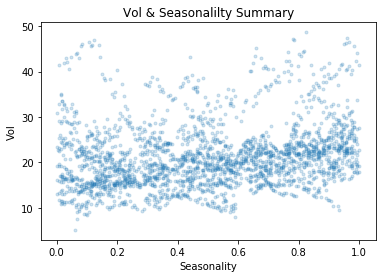

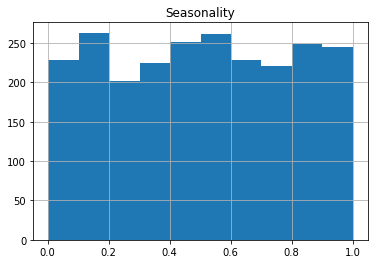

In [68]:
# create scatter plot of vols vs. seasonality
plt.scatter(final_data['Seasonality'], final_data['Vol'], marker='.', alpha=0.2)
plt.title('Vol & Seasonalilty Summary')
plt.xlabel('Seasonality')
plt.ylabel('Vol')

# create pandas histogram
final_data.hist(column='Seasonality', bins=10)

C:\Users\Trader\Anaconda3\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


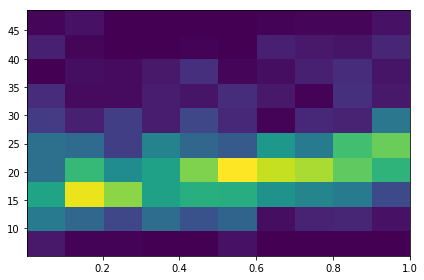

In [79]:
# creates a 2-D histogram of seasonality vs. volatility

fig, ax = plt.subplots(tight_layout=True)
hist = ax.hist2d(final_data['Seasonality'], final_data['Vol'])

### Fitting functions to seasonality / vol data

Below, we attempt to fit a curve to our data with a sigmoid function, then an arc tangent function. The working hypothesis is that volatility should be highest during the 'high seasonality' months and increase or decrease rapidly during the spring and fall.

#### Create and test sigmoid function

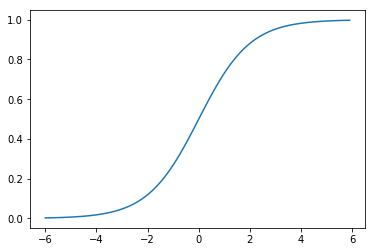

In [80]:
# create an array of numbers -6.0 to +6.0 and plot the sigmoid function using that array as input

x = np.arange(-6.0,6.0,0.1)
y = 1 / (1 + np.exp(-x))
plt.plot(x,y)
plt.show()

In [83]:
# define the sigmoid function that will be used in scipy.curve_fit
# this can be substituted with scipy.special.expit(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# define our function to fit the sigmoid curve to our vol data with a k variable, min vol, and range

def sig_fit(x, k, breadth, minimum):
    '''
    x is the seasonality parameter, k is a weight to adjust that parameter,
    breadth describes the distance between the highest and lowest vol in the sig_fit function,
    minimum is the lowest vol possible in the sig_fit function
    '''
    return (1 / (1 + np.exp(-x*k)) * breadth) + minimum

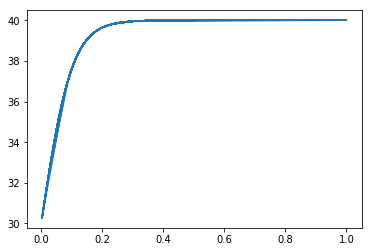

In [115]:
plt.plot(Xdata, sig_fit(Xdata, 20,20,20))

#### Fitting the sig_fit function to implied volatility data

In [108]:
Xdata = final_data['Seasonality']
ydata = final_data['Vol']

# forced parameters to display nice sigmoid curve, straight line without
# the nature of seasonality sine curve might be offsetting expected result
# if seasonality was linear, the optimal curve might more reflect the sigmoid we expected

force_opt, force_cov = curve_fit(sig_fit, Xdata, ydata, bounds=([5,10,10],[8,30,30]))
popt, pcov = curve_fit(sig_fit, Xdata, ydata, bounds=([-4,-1000,-1000],[4,1000,1000]))

print(popt)
print(pcov)

[ 3.62655764e-02  5.75130680e+02 -2.68991084e+02]
[[ 1.50742912e+03 -2.39013714e+07  1.19506761e+07]
 [-2.39013714e+07  3.78973413e+11 -1.89486555e+11]
 [ 1.19506761e+07 -1.89486555e+11  9.47432013e+10]]


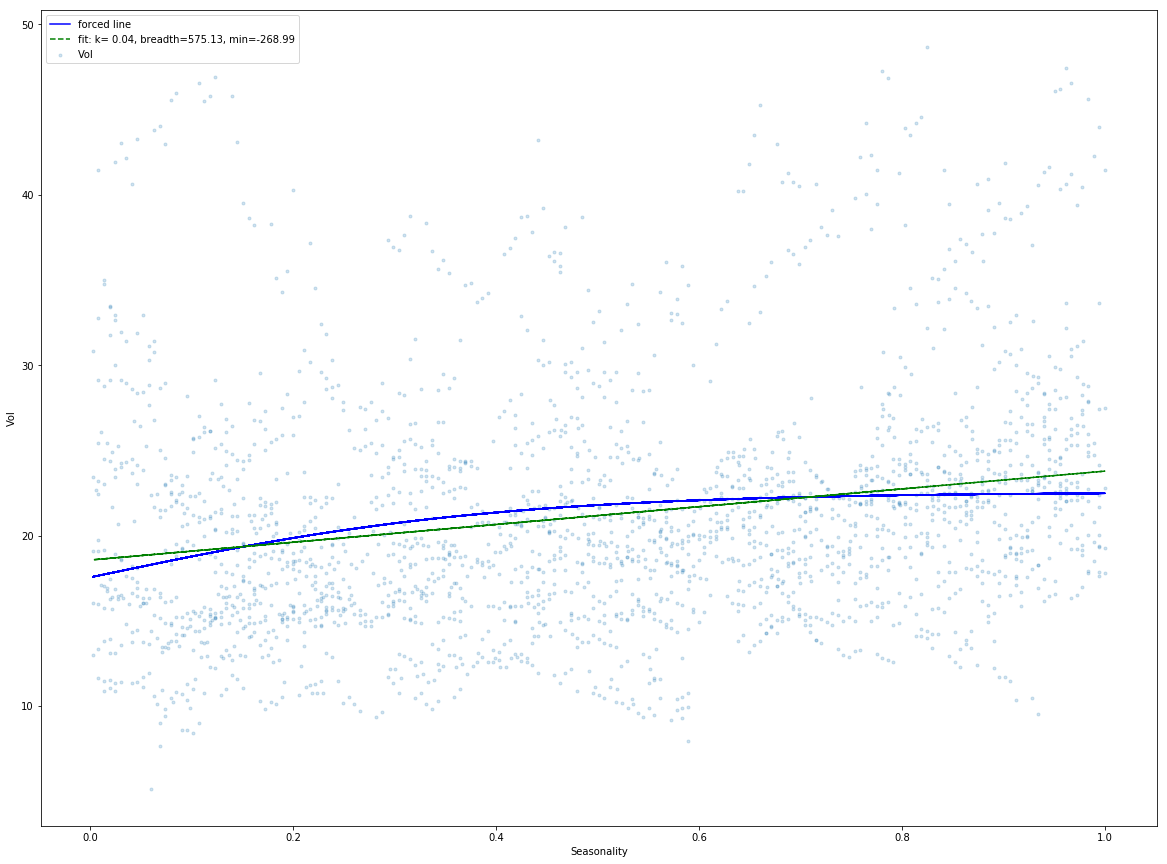

In [109]:
plt.figure(figsize=(20,15))
plt.scatter(final_data['Seasonality'], final_data['Vol'], marker='.', alpha=0.2)
plt.plot(Xdata, sig_fit(Xdata, *force_opt), 'b-', label='forced line')
plt.plot(Xdata, sig_fit(Xdata, *popt), 'g--', label='fit: k=%5.2f, breadth=%5.2f, min=%5.2f' % tuple(popt))
plt.ylabel('Vol')
plt.xlabel('Seasonality')
plt.legend()
plt.show()

### Creating a more reasonable model

Looking at the data below, we see there is a lot a variance to the implied vol numbers in 2009 and 2012 due to the commodities bubble and financial crisis during 2009, and a major drought in the US during the summer of 2012. Removing this data will give us a better model of pure seasonality at the expense of making the model less reliable in periods of extreme volatility.

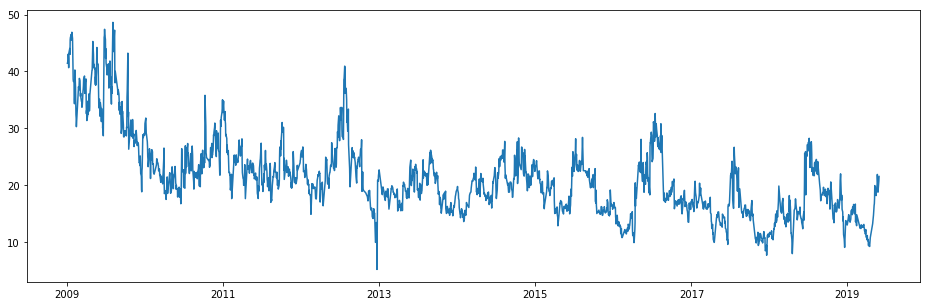

In [122]:
plt.figure(figsize=(16,5))
plt.plot(final_data['Observation Date'], final_data['Vol'])
plt.show()

In [126]:
# remove data before 2014

recent_data = final_data[final_data['Year'] > 2013]
recent_data.describe()

,Year,Vol,DTE,Seasonality
count,1281.000000,1281.000000,1281,1281.000000
mean,2016.295082,17.832685,31 days 03:04:21.358313,0.488266
std,1.631827,4.448514,15 days 18:04:49.263334,0.291410
min,2014.000000,7.660000,6 days 00:00:00,0.002740
25%,2015.000000,14.920000,18 days 00:00:00,0.227397
50%,2016.000000,17.120000,30 days 00:00:00,0.484932
75%,2018.000000,20.919999,44 days 00:00:00,0.747945
max,2019.000000,32.599999,60 days 00:00:00,1.000000


#### Fitting the sig_fit curve to the recent data subset

In [130]:
Xdata = recent_data['Seasonality']
ydata = recent_data['Vol']

popt, pcov = curve_fit(sig_fit, Xdata, ydata, bounds=([0, 0, 0], [10, 40, 40]))

print(popt)

[9.32904813e-01 2.92464050e+01 2.72951130e-10]


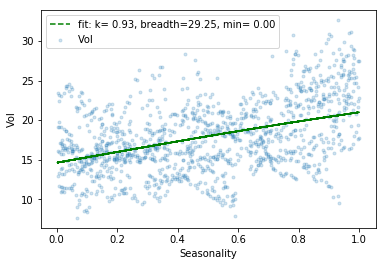

In [133]:
# plotting sig_fit curve against vol data

plt.scatter(recent_data['Seasonality'], recent_data['Vol'], marker='.', alpha=0.2)
plt.plot(Xdata, sig_fit(Xdata, *popt), 'g--', label='fit: k=%5.2f, breadth=%5.2f, min=%5.2f' % tuple(popt))
plt.ylabel('Vol')
plt.xlabel('Seasonality')
plt.legend()
plt.show()

Despite limiting the data to the most recent 5 years, we still see a very linear relationship between seasonality and implied volatility

#### Fitting arc tangent function to seasonality / vol data

In [134]:
# creating function for arc tangent fit

def arc_fit(x, k, breadth, minimum):
    return (np.arctan(x*k) * breadth) + minimum

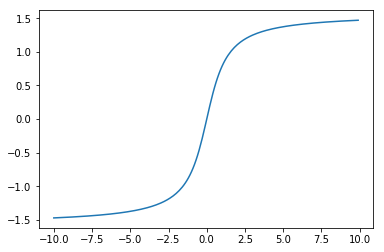

In [135]:
# double check functionality

x = np.arange(-10,10,.1)
y = np.arctan(x)
plt.plot(x,y)
plt.show()

In [137]:
# fit arc tangent function to vol data

popt_arc, pcov = curve_fit(arc_fit, Xdata, ydata, bounds=([0, 0, 0], [10, 40, 50]))

print(popt_arc)

[ 0.16938612 40.         14.53998387]


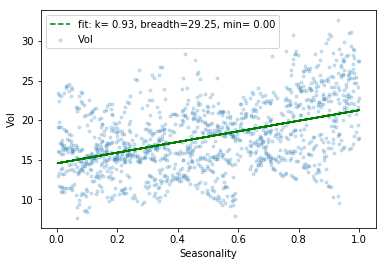

In [139]:
#plt.figure(figsize=(20,15))
plt.scatter(recent_data['Seasonality'], recent_data['Vol'], marker='.', alpha=0.2)
plt.plot(Xdata, arc_fit(Xdata, *popt_arc), 'g--', label='fit: k=%5.2f, breadth=%5.2f, min=%5.2f' % tuple(popt))
plt.xlabel('Seasonality')
plt.ylabel('Vol')
plt.legend()
plt.show()

### Conculsion from sinusoidal modeling

As expected, the arc tangent curve produces a result very similar to the sig_fit function created earlier. There is a very linear relationship between seasonality and implied volatility, not the sinusoidal curve we expected. This is not the best way to model seasonality of implied volatility in CBOT grain products. Going forward, we can attempt to fit a high-order polynomial curve, then a cubic spline to create a better model.

### Create a seasonally adjusted implied volatility

Prior to advancing to any other models, we want to see if using the linear seasonality model and adjusting impled vols based on the calendar day number helps to draw a conclusion. Looking at the maximum implied vol in a given year, it seems that late July is an accurate point of max seasonality.

In [140]:
# create a list of lists to append years of data to

year_range = range(2013,2019)
df_by_year = []
for year in year_range:
    data = final_data[final_data['Year'] == year]
    df_by_year.append(data)

In [155]:
# alternate pythonic way to create list of lists

year_range = range(2013, 2019)
df_by_year = [final_data[final_data['Year'] == year] for year in year_range]

In [157]:
# check maximum implied vol for each calendar year

max_by_year = []
for year in df_by_year:
    max_vol = year['Vol'].idxmax()
    max_by_year.append(year.loc[max_vol])
print(max_by_year)

[Observation Date    2013-08-29 00:00:00
Year                               2013
Vol                               26.14
Expiry              2013-10-25 00:00:00
DTE                    57 days 00:00:00
Seasonality                    0.682192
Name: 18596, dtype: object, Observation Date    2014-10-15 00:00:00
Year                               2014
Vol                                28.3
Expiry              2014-10-24 00:00:00
DTE                     9 days 00:00:00
Seasonality                    0.424658
Name: 23339, dtype: object, Observation Date    2015-08-10 00:00:00
Year                               2015
Vol                                28.4
Expiry              2015-08-21 00:00:00
DTE                    11 days 00:00:00
Seasonality                    0.786301
Name: 22132, dtype: object, Observation Date    2016-07-15 00:00:00
Year                               2016
Vol                                32.6
Expiry              2016-07-24 00:00:00
DTE                     9 days 00:0

In [158]:
recent_data['Predicted Vol'] = recent_data.apply(lambda x: sig_fit(x['Seasonality'], *popt), axis=1)

recent_data['Adj Vol'] = recent_data['Vol'] - recent_data['Predicted Vol']

C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [159]:
recent_data.head()

,Observation Date,Year,Vol,Expiry,DTE,Seasonality,Predicted Vol,Adj Vol
18647,2013-10-28,2014,18.34,2013-12-26,59 days,0.353425,17.012318,1.327682
18664,2013-10-29,2014,17.98,2013-12-26,58 days,0.347945,16.975925,1.004075
18681,2013-10-30,2014,17.52,2013-12-26,57 days,0.342466,16.939502,0.580498
18698,2013-10-31,2014,17.80,2013-12-26,56 days,0.336986,16.903049,0.896950
18715,2013-11-01,2014,18.62,2013-12-26,55 days,0.331507,16.866568,1.753432


Text(0,0.5,'Predicted Vol')

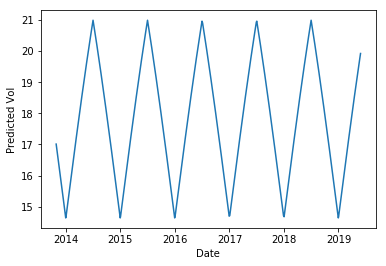

In [164]:
plt.plot(recent_data['Observation Date'], recent_data['Predicted Vol'])
plt.xlabel('Date')
plt.ylabel('Predicted Vol')

Text(0,0.5,'Imp Vol')

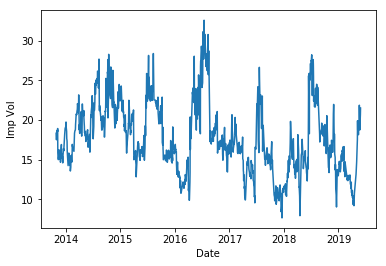

In [165]:
plt.plot(recent_data['Observation Date'], recent_data['Vol'])
plt.xlabel('Date')
plt.ylabel('Imp Vol')

Text(0,0.5,'Adj Vol')

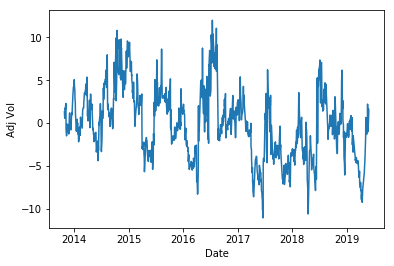

In [166]:
plt.plot(recent_data['Observation Date'], recent_data['Adj Vol'])
plt.xlabel('Date')
plt.ylabel('Adj Vol')

In [153]:
recent_data.describe()

,Year,Vol,DTE,Seasonality
count,1281.000000,1281.000000,1281,1281.000000
mean,2016.295082,17.832685,31 days 03:04:21.358313,0.488266
std,1.631827,4.448514,15 days 18:04:49.263334,0.291410
min,2014.000000,7.660000,6 days 00:00:00,0.002740
25%,2015.000000,14.920000,18 days 00:00:00,0.227397
50%,2016.000000,17.120000,30 days 00:00:00,0.484932
75%,2018.000000,20.919999,44 days 00:00:00,0.747945
max,2019.000000,32.599999,60 days 00:00:00,1.000000


Simply looking at the charts of implied vol and adjusted vol, it appears that the current model does not substantially reduce noise. The linear seasonality parameter reduces interquartile range by `0.26` between Vol and Adj Vol, and the sine wave seasonality parameter reduces interquartile range by `0.14` between Vol and Adj Vol

## 2. Polynomial curve fit

In [485]:
recent_data2 = final_data[final_data['Year'] > 2013]

In [486]:
def day_num(date):
    year = date.year
    start = pd.datetime(year-1,12,31)
    day = date - start
    return(day.days)

In [487]:
day_num(pd.datetime(2012,12,31))

366

In [488]:
recent_data2['Day Num'] = recent_data2.apply(lambda x: day_num(x['Observation Date']), axis=1)

C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [489]:
recent_data2

,Observation Date,Year,Vol,Expiry,DTE,Seasonality,Day Num
18647,2013-10-28,2014,18.340000,2013-12-26,59 days,0.353425,301
18664,2013-10-29,2014,17.980000,2013-12-26,58 days,0.347945,302
18681,2013-10-30,2014,17.520000,2013-12-26,57 days,0.342466,303
18698,2013-10-31,2014,17.800000,2013-12-26,56 days,0.336986,304
18715,2013-11-01,2014,18.620000,2013-12-26,55 days,0.331507,305
18732,2013-11-04,2014,18.340000,2013-12-26,52 days,0.315068,308
18749,2013-11-05,2014,18.740000,2013-12-26,51 days,0.309589,309
18766,2013-11-06,2014,18.540000,2013-12-26,50 days,0.304110,310
18783,2013-11-07,2014,18.940000,2013-12-26,49 days,0.298630,311
18800,2013-11-08,2014,15.880000,2013-12-26,48 days,0.293151,312


In [490]:
X = recent_data2['Day Num']
y = recent_data2['Vol']
degree = 15
coef = np.polyfit(X, y, degree)

In [491]:
coef

array([-1.65766428e-30,  4.56958161e-27, -5.66269501e-24,  4.16617400e-21,
       -2.02452560e-18,  6.84015421e-16, -1.64740752e-13,  2.85338935e-11,
       -3.54211860e-09,  3.10512291e-07, -1.87014320e-05,  7.40794023e-04,
       -1.80625033e-02,  2.45444541e-01, -1.60372451e+00,  1.98102839e+01])

In [492]:
curve = list()
for i in X:
    value = coef[0] * i**3 + coef[1] * i**2 + coef[2] * i**1 + coef[-1]
    curve.append(value)

In [493]:
curve = list()
for i in X:
    value = coef[-1]
    for d in range(degree):
        value += coef[d] * i**(degree-d)
    curve.append(value)

In [494]:
len(curve)

1281

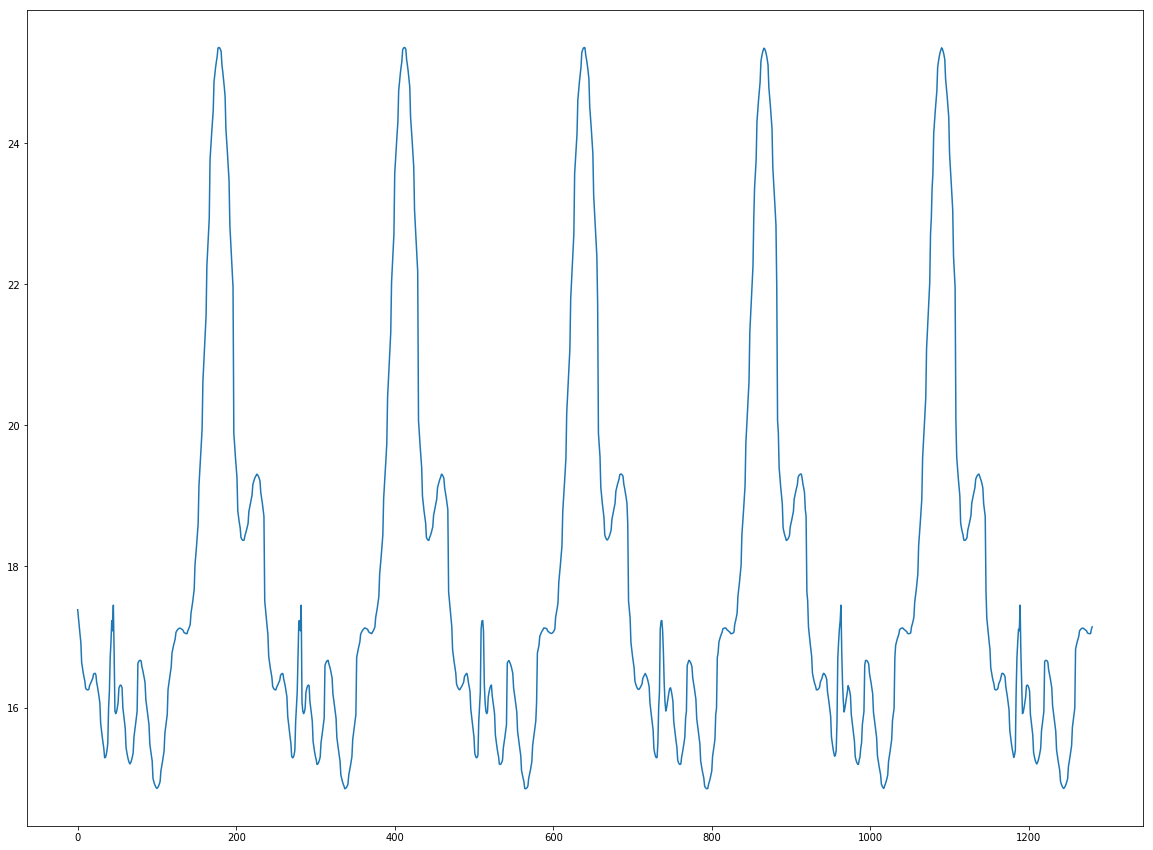

In [495]:
plt.figure(figsize=(20,15))
plt.plot(curve)

In [496]:
recent_data2['Curve'] = curve

C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


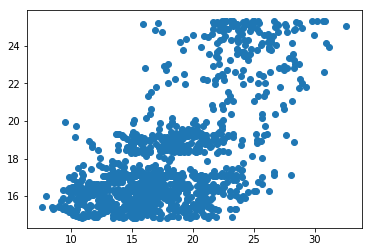

In [497]:
plt.scatter(recent_data2['Vol'], recent_data2['Curve'])

In [498]:
recent_data2['Adj Vol'] = recent_data2['Vol'] - recent_data2['Curve']

C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


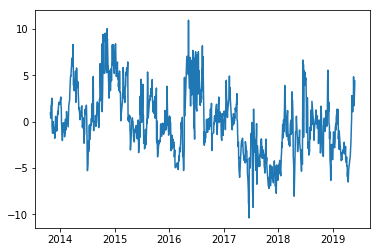

In [499]:
plt.plot(recent_data2['Observation Date'], recent_data2['Adj Vol'])

In [500]:
recent_data2['Vol Prev'] = recent_data2['Vol'].shift(1)

C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [501]:
recent_data2['Vol Chg'] = recent_data2['Vol'] - recent_data2['Vol Prev']

C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


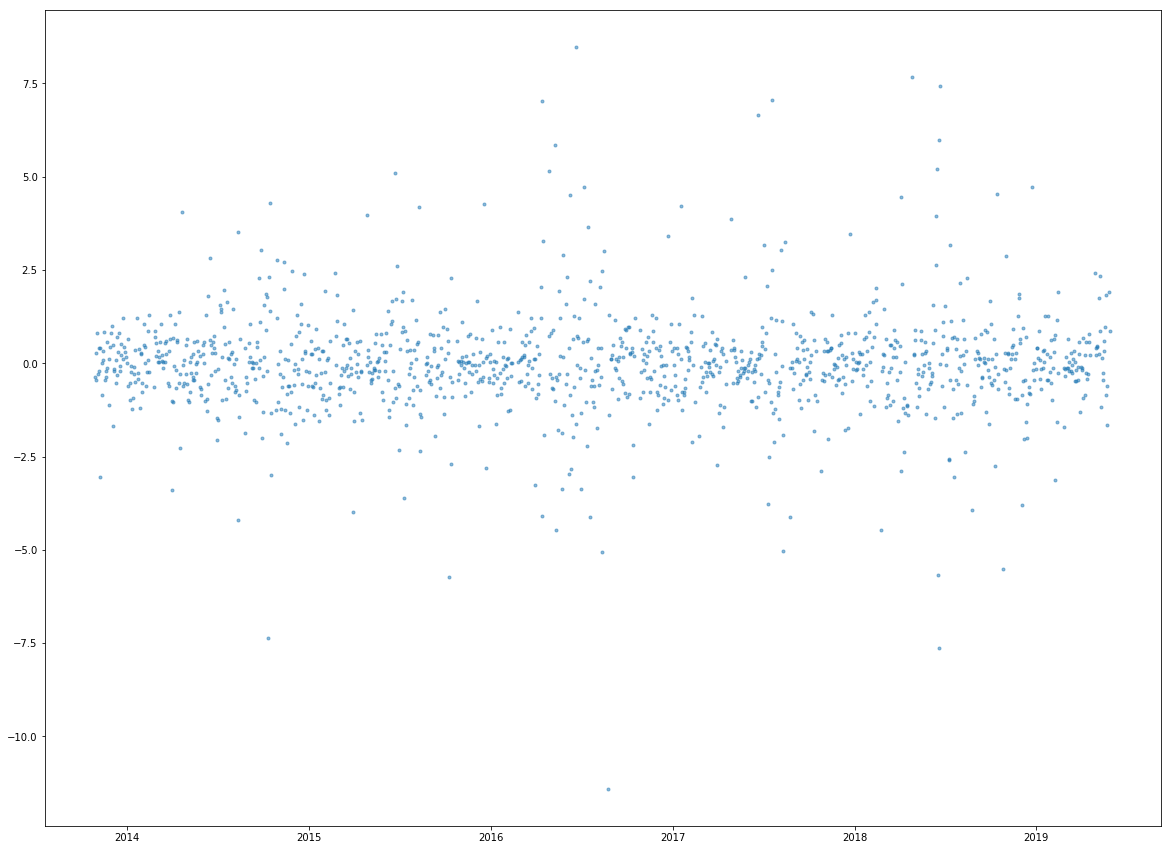

In [502]:
plt.figure(figsize=(20,15))
plt.plot_date(recent_data2['Observation Date'], recent_data2['Vol Chg'], alpha=0.5, marker='.')

In [503]:
recent_data2['Avg Vol'] = recent_data2['Vol'].rolling(10,1).mean()

C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [504]:
recent_data2['Avg Vol Prev'] = recent_data2['Avg Vol'].shift(1)
recent_data2['Avg Vol Chg'] = recent_data2['Avg Vol'] - recent_data2['Avg Vol Prev']


C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


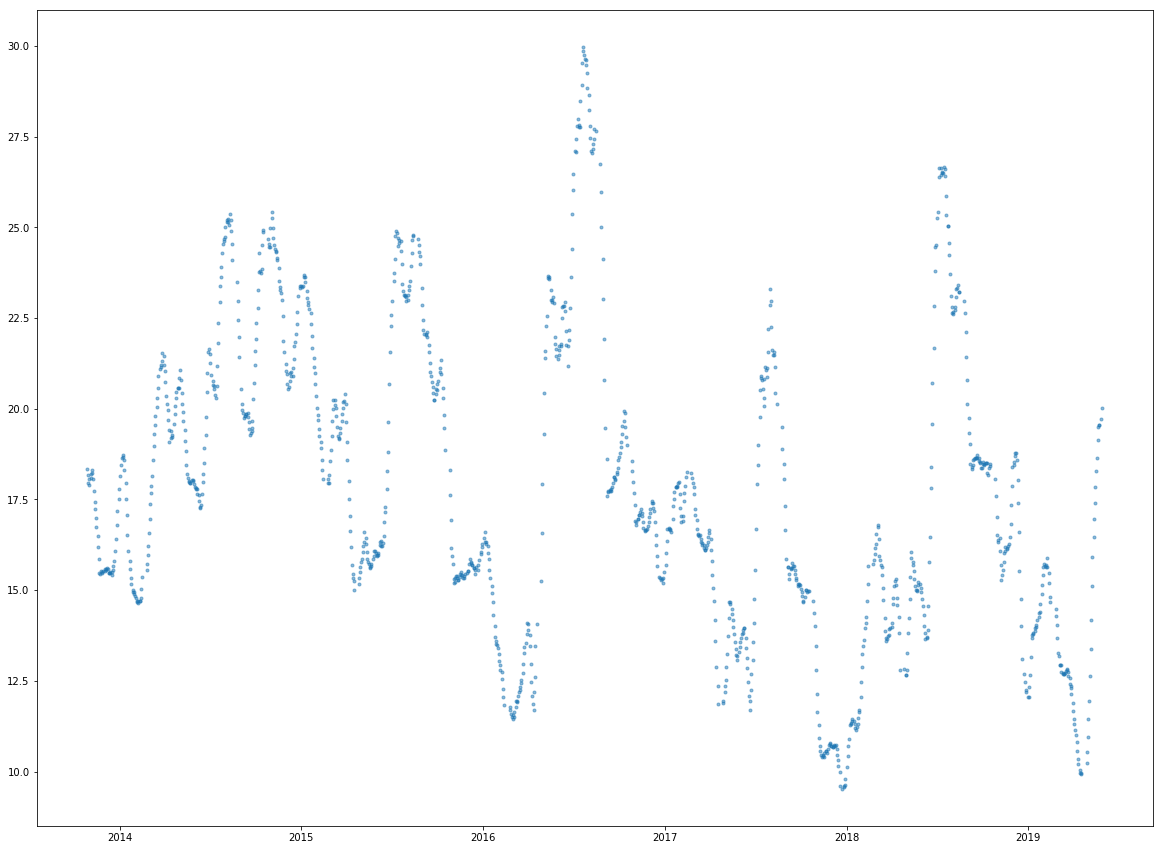

In [505]:
plt.figure(figsize=(20,15))
plt.plot_date(recent_data2['Observation Date'], recent_data2['Avg Vol'], alpha=0.5, marker='.')

In [506]:
recent_data2

,Observation Date,Year,Vol,Expiry,DTE,Seasonality,Day Num,Curve,Adj Vol,Vol Prev,Vol Chg,Avg Vol,Avg Vol Prev,Avg Vol Chg
18647,2013-10-28,2014,18.340000,2013-12-26,59 days,0.353425,301,17.387064,0.952936,NaN,NaN,18.340000,NaN,NaN
18664,2013-10-29,2014,17.980000,2013-12-26,58 days,0.347945,302,17.265103,0.714897,18.340000,-0.36,18.160000,18.340000,-0.180000
18681,2013-10-30,2014,17.520000,2013-12-26,57 days,0.342466,303,17.146909,0.373091,17.980000,-0.46,17.946666,18.160000,-0.213333
18698,2013-10-31,2014,17.800000,2013-12-26,56 days,0.336986,304,17.033366,0.766634,17.520000,0.28,17.910000,17.946666,-0.036667
18715,2013-11-01,2014,18.620000,2013-12-26,55 days,0.331507,305,16.925311,1.694688,17.800000,0.82,18.052000,17.910000,0.142000
18732,2013-11-04,2014,18.340000,2013-12-26,52 days,0.315068,308,16.641492,1.698508,18.620000,-0.28,18.100000,18.052000,0.048000
18749,2013-11-05,2014,18.740000,2013-12-26,51 days,0.309589,309,16.562416,2.177584,18.340000,0.40,18.191428,18.100000,0.091429
18766,2013-11-06,2014,18.540000,2013-12-26,50 days,0.304110,310,16.491918,2.048082,18.740000,-0.20,18.235000,18.191428,0.043571
18783,2013-11-07,2014,18.940000,2013-12-26,49 days,0.298630,311,16.430325,2.509675,18.540000,0.40,18.313333,18.235000,0.078333
18800,2013-11-08,2014,15.880000,2013-12-26,48 days,0.293151,312,16.377854,-0.497855,18.940000,-3.06,18.070000,18.313333,-0.243333


In [507]:
recent_data2[recent_data2['Avg Vol Chg'] > 0.8]

,Observation Date,Year,Vol,Expiry,DTE,Seasonality,Day Num,Curve,Adj Vol,Vol Prev,Vol Chg,Avg Vol,Avg Vol Prev,Avg Vol Chg
22676,2015-06-25,2015,23.279999,2015-07-24,29 days,0.961644,176,21.087029,2.192970,21.559999,1.72,19.644000,18.810000,0.834
22693,2015-06-26,2015,25.879999,2015-07-24,28 days,0.967123,177,21.321169,4.558830,23.279999,2.60,20.688000,19.644000,1.044
22710,2015-06-29,2015,25.319999,2015-07-24,25 days,0.983562,180,22.025389,3.294610,25.879999,-0.56,21.569999,20.688000,0.882
29935,2016-04-15,2016,19.580000,2016-04-24,9 days,0.573770,106,15.810957,3.769043,16.300000,3.28,13.462000,12.616000,0.846
30190,2016-04-27,2016,22.819999,2016-06-26,60 days,0.639344,118,16.773316,6.046683,17.660000,5.16,15.250000,14.070000,1.180
30207,2016-04-28,2016,23.539999,2016-06-26,59 days,0.644809,119,16.830286,6.709714,22.819999,0.72,16.584000,15.250000,1.334
30224,2016-04-29,2016,23.259999,2016-06-26,58 days,0.650273,120,16.882266,6.377733,23.539999,-0.28,17.922000,16.584000,1.338
30241,2016-05-02,2016,24.059999,2016-06-26,55 days,0.666667,123,17.007339,7.052660,23.259999,0.80,19.316000,17.922000,1.394
30258,2016-05-03,2016,23.399999,2016-06-26,54 days,0.672131,124,17.038694,6.361305,24.059999,-0.66,20.440000,19.316000,1.124
30275,2016-05-04,2016,22.999999,2016-06-26,53 days,0.677596,125,17.064992,5.935008,23.399999,-0.40,21.401999,20.440000,0.962


In [508]:
recent_data2[-0.75 > recent_data2['Avg Vol Chg']]

,Observation Date,Year,Vol,Expiry,DTE,Seasonality,Day Num,Curve,Adj Vol,Vol Prev,Vol Chg,Avg Vol,Avg Vol Prev,Avg Vol Chg
22812,2014-09-02,2014,18.78,2014-10-24,52 days,0.660274,245,18.784992,-0.004993,18.740000,0.04,20.540000,21.431999,-0.892
27130,2015-10-29,2016,15.22,2015-12-25,57 days,0.347945,302,17.265103,-2.045103,15.200000,0.02,16.156000,16.924000,-0.768
30513,2016-05-24,2016,18.74,2016-06-26,33 days,0.786885,145,17.058349,1.681651,20.599999,-1.86,21.977999,22.909999,-0.932
31125,2016-08-24,2016,17.34,2016-10-23,60 days,0.710383,237,19.890771,-2.550771,28.739999,-11.40,26.739999,27.649999,-0.910
31142,2016-08-25,2016,18.64,2016-10-23,59 days,0.704918,238,19.718159,-1.078160,17.340000,1.30,25.963999,26.739999,-0.776
31159,2016-08-26,2016,17.24,2016-10-23,58 days,0.699454,239,19.554486,-2.314486,18.640000,-1.40,25.005999,25.963999,-0.958
31176,2016-08-29,2016,17.34,2016-10-23,55 days,0.683060,242,19.122013,-1.782013,17.240000,0.10,24.115999,25.005999,-0.890
31193,2016-08-30,2016,17.46,2016-10-23,54 days,0.677596,243,18.998694,-1.538694,17.340000,0.12,23.033999,24.115999,-1.082
31210,2016-08-31,2016,17.68,2016-10-23,53 days,0.672131,244,18.886289,-1.206290,17.460000,0.22,21.931999,23.033999,-1.102
31227,2016-09-01,2016,16.98,2016-10-23,52 days,0.666667,245,18.784992,-1.804993,17.680000,-0.70,20.796000,21.931999,-1.136


In [509]:
data_2015 = recent_data2[(recent_data2['Observation Date'] <= pd.datetime(2015,12,31))
                         & (recent_data2['Observation Date'] >= pd.datetime(2015,1,1))]

In [510]:
data_2014 = recent_data2[(recent_data2['Observation Date'] <= pd.datetime(2014,12,31))
                         & (recent_data2['Observation Date'] >= pd.datetime(2014,1,1))]
data_2016 = recent_data2[(recent_data2['Observation Date'] <= pd.datetime(2016,12,31))
                         & (recent_data2['Observation Date'] >= pd.datetime(2016,1,1))]
data_2017 = recent_data2[(recent_data2['Observation Date'] <= pd.datetime(2017,12,31))
                         & (recent_data2['Observation Date'] >= pd.datetime(2017,1,1))]
data_2018 = recent_data2[(recent_data2['Observation Date'] <= pd.datetime(2018,12,31))
                         & (recent_data2['Observation Date'] >= pd.datetime(2018,1,1))]

In [511]:
years = range(2014,2019)

In [512]:
for year in years:
    print(year)

2014
2015
2016
2017
2018


In [513]:
data_by_year = []
for year in years:
    data = recent_data2[(recent_data2['Observation Date'] <= pd.datetime(year,12,31))
                         & (recent_data2['Observation Date'] >= pd.datetime(year,1,1))]
    data = data[['Day Num','Vol']]
    data.set_index('Day Num', inplace=True)
    data_by_year.append(data)

In [514]:
data_by_year

[               Vol
 Day Num           
 2        19.760000
 3        19.140000
 6        18.600000
 7        17.620000
 8        17.540000
 9        17.300000
 10       16.080000
 13       15.160000
 14       14.860000
 15       14.760000
 16       14.260000
 17       14.620000
 21       15.840000
 22       15.420000
 23       15.160000
 24       15.540000
 27       14.340000
 28       14.600000
 29       14.880000
 30       14.340000
 31       13.580000
 34       14.060000
 35       15.120000
 36       15.120000
 37       15.560000
 38       14.940000
 41       14.700000
 42       14.780000
 43       15.640000
 44       16.940000
 ...            ...
 322      22.199999
 323      22.279999
 324      21.679999
 325      21.079999
 328      19.760000
 329      19.000000
 330      19.520000
 332      21.979999
 335      21.789999
 336      21.219999
 337      21.199999
 338      19.560000
 339      20.300000
 342      21.579999
 343      21.419999
 344      21.139999
 345      19.980000


In [515]:
day_vols = data_by_year[0]
len(day_vols)

237

In [516]:
data_by_year[0]

,Vol
Day Num,
2,19.760000
3,19.140000
6,18.600000
7,17.620000
8,17.540000
9,17.300000
10,16.080000
13,15.160000
14,14.860000


In [517]:
day_vols.join(data_by_year[1], on='Day Num', rsuffix='_2015')

,Vol,Vol_2015
Day Num,,
2,19.760000,23.199999
3,19.140000,NaN
6,18.600000,24.059999
7,17.620000,24.299999
8,17.540000,23.699999
9,17.300000,23.059999
10,16.080000,NaN
13,15.160000,21.119999
14,14.860000,21.499999


In [518]:
days_df = pd.DataFrame({'Day Num': range(0,367)})

In [519]:
days_df = days_df.join(data_by_year[0], on='Day Num', rsuffix='_2014')
days_df.rename(columns={'Vol': '2014'}, inplace=True)

days_df = days_df.join(data_by_year[1], on='Day Num', rsuffix='_2015')
days_df.rename(columns={'Vol': '2015'}, inplace=True)

days_df = days_df.join(data_by_year[2], on='Day Num', rsuffix='_2016')
days_df.rename(columns={'Vol': '2016'}, inplace=True)

days_df = days_df.join(data_by_year[3], on='Day Num', rsuffix='_2017')
days_df.rename(columns={'Vol': '2017'}, inplace=True)

days_df = days_df.join(data_by_year[4], on='Day Num', rsuffix='_2018')
days_df.rename(columns={'Vol': '2018'}, inplace=True)

In [520]:
print(days_df)

     Day Num       2014       2015   2016   2017   2018
0          0        NaN        NaN    NaN    NaN    NaN
1          1        NaN        NaN    NaN    NaN    NaN
2          2  19.760000  23.199999    NaN    NaN  11.68
3          3  19.140000        NaN    NaN  17.06  11.50
4          4        NaN        NaN  16.94  17.48  11.54
5          5        NaN  23.459999  16.42  16.86  11.38
6          6  18.600000  24.059999  16.26  16.54    NaN
7          7  17.620000  24.299999  16.32    NaN    NaN
8          8  17.540000  23.699999  16.00    NaN  11.38
9          9  17.300000  23.059999    NaN  16.94  11.42
10        10  16.080000        NaN    NaN  16.08  11.72
11        11        NaN        NaN  16.04  16.32  11.96
12        12        NaN  21.659999  14.42  15.34  10.60
13        13  15.160000  21.119999  14.02  16.38    NaN
14        14  14.860000  21.499999  13.16    NaN    NaN
15        15  14.760000  22.419999  13.72    NaN    NaN
16        16  14.260000  22.099999    NaN    NaN

In [521]:
# impute implied volatility for days with 'NaN' in days_df dataframe
# because NaN values are weekend days or holidays, 
# we can assume the implied volatility for that day is equal to the most recent previous day. 
# i.e. The implied vol on Saturday when markets are closed is assumed to be the implied vol at close on Friday

days_df = days_df.fillna(method='ffill')
days_df = days_df.fillna(method='bfill')

In [522]:
print(days_df)

     Day Num       2014       2015   2016   2017   2018
0          0  19.760000  23.199999  16.94  17.06  11.68
1          1  19.760000  23.199999  16.94  17.06  11.68
2          2  19.760000  23.199999  16.94  17.06  11.68
3          3  19.140000  23.199999  16.94  17.06  11.50
4          4  19.140000  23.199999  16.94  17.48  11.54
5          5  19.140000  23.459999  16.42  16.86  11.38
6          6  18.600000  24.059999  16.26  16.54  11.38
7          7  17.620000  24.299999  16.32  16.54  11.38
8          8  17.540000  23.699999  16.00  16.54  11.38
9          9  17.300000  23.059999  16.00  16.94  11.42
10        10  16.080000  23.059999  16.00  16.08  11.72
11        11  16.080000  23.059999  16.04  16.32  11.96
12        12  16.080000  21.659999  14.42  15.34  10.60
13        13  15.160000  21.119999  14.02  16.38  10.60
14        14  14.860000  21.499999  13.16  16.38  10.60
15        15  14.760000  22.419999  13.72  16.38  10.60
16        16  14.260000  22.099999  13.72  16.38

In [523]:
#days_df.set_index('Day Num', inplace=True)

days_df['Day Avg Vol'] = days_df[['2014', '2015', '2016', '2017', '2018']].mean(axis=1)

In [524]:
print(days_df)

     Day Num       2014       2015   2016   2017   2018  Day Avg Vol
0          0  19.760000  23.199999  16.94  17.06  11.68       17.728
1          1  19.760000  23.199999  16.94  17.06  11.68       17.728
2          2  19.760000  23.199999  16.94  17.06  11.68       17.728
3          3  19.140000  23.199999  16.94  17.06  11.50       17.568
4          4  19.140000  23.199999  16.94  17.48  11.54       17.660
5          5  19.140000  23.459999  16.42  16.86  11.38       17.452
6          6  18.600000  24.059999  16.26  16.54  11.38       17.368
7          7  17.620000  24.299999  16.32  16.54  11.38       17.232
8          8  17.540000  23.699999  16.00  16.54  11.38       17.032
9          9  17.300000  23.059999  16.00  16.94  11.42       16.944
10        10  16.080000  23.059999  16.00  16.08  11.72       16.588
11        11  16.080000  23.059999  16.04  16.32  11.96       16.692
12        12  16.080000  21.659999  14.42  15.34  10.60       15.620
13        13  15.160000  21.119999

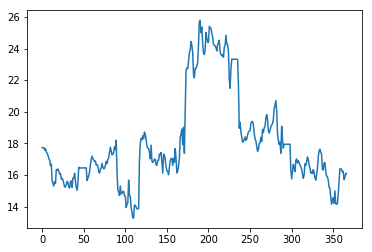

In [525]:
plt.plot(days_df['Day Num'], days_df['Day Avg Vol'])

In [526]:
days_df[360:367]

,Day Num,2014,2015,2016,2017,2018,Day Avg Vol
360,360,24.279999,16.66,15.88,11.40,13.58,16.360
361,361,24.279999,16.66,15.88,10.92,13.14,16.176
362,362,24.279999,16.26,16.44,11.04,13.14,16.232
363,363,23.019999,15.76,15.72,10.88,13.14,15.704
364,364,22.419999,16.02,16.78,10.88,13.14,15.848
365,365,23.439999,16.04,17.12,10.88,12.98,16.092
366,366,23.439999,16.04,17.12,10.88,12.98,16.092


In [527]:
print(days_df.at[0, 'Day Avg Vol'])
print(days_df.at[366, 'Day Avg Vol'])

17.727999578000002
16.091999618


In [528]:
# need to set last value equal to first value to force CubicSpline

In [529]:
days_df.at[366, 'Day Avg Vol'] = days_df.at[0, 'Day Avg Vol']

In [530]:
print(days_df.at[0, 'Day Avg Vol'])
print(days_df.at[366, 'Day Avg Vol'])

17.727999578000002
17.727999578000002


In [533]:
#spline = sp.interpolate.interp1d(Xdata, ydata, kind='cubic')

In [534]:
spline

In [535]:
spline2 = CubicSpline([1,2,3,4], [3,1,3,1])

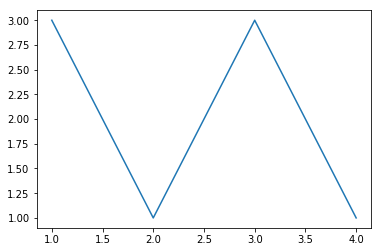

In [536]:
plt.plot([1,2,3,4], spline2([1,2,3,4]))

In [537]:
Xdata = days_df['Day Num']
ydata = days_df['Day Avg Vol']

cs = CubicSpline(Xdata, ydata, bc_type='periodic')

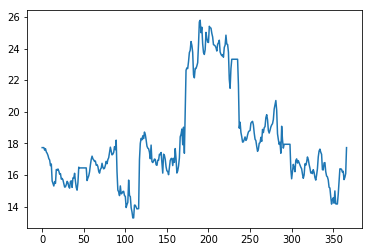

In [538]:
# plots first derivative of cubic spline

plt.plot(range(0,367), cs(range(0,367)), label="S")

Were going to implement a regression spline using knots along the path of average vol through the year. 

In [539]:
ydata

0      17.728
1      17.728
2      17.728
3      17.568
4      17.660
5      17.452
6      17.368
7      17.232
8      17.032
9      16.944
10     16.588
11     16.692
12     15.620
13     15.456
14     15.300
15     15.576
16     15.464
17     16.344
18     16.300
19     16.376
20     16.248
21     16.052
22     16.084
23     15.736
24     15.780
25     15.684
26     15.464
27     15.232
28     15.244
29     15.388
        ...  
337    16.332
338    16.316
339    16.760
340    16.780
341    16.204
342    15.936
343    15.876
344    15.684
345    15.220
346    15.172
347    14.624
348    14.152
349    14.416
350    14.552
351    14.212
352    14.988
353    14.172
354    14.160
355    14.160
356    14.764
357    15.528
358    16.384
359    16.384
360    16.360
361    16.176
362    16.232
363    15.704
364    15.848
365    16.092
366    17.728
Name: Day Avg Vol, Length: 367, dtype: float64

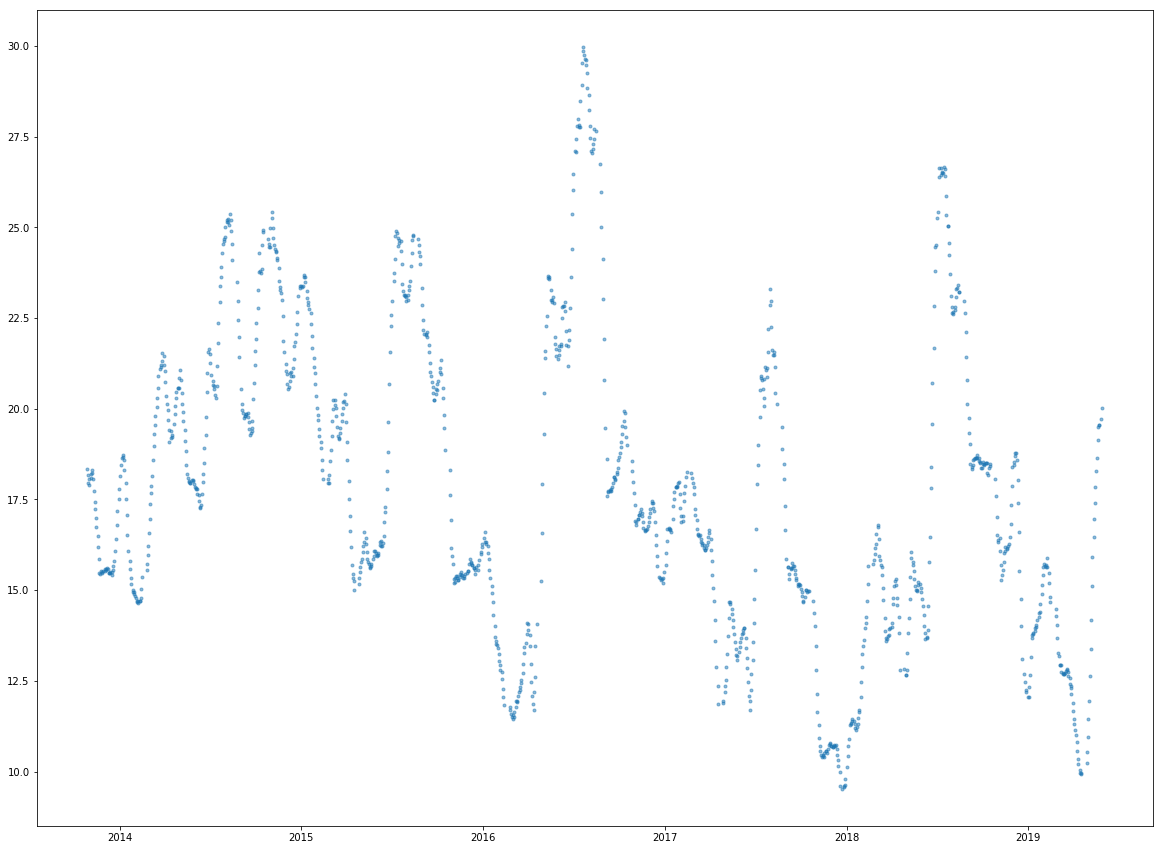

In [540]:
plt.figure(figsize=(20,15))
plt.plot_date(recent_data2['Observation Date'], recent_data2['Avg Vol'], alpha=0.5, marker='.')

In [541]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [542]:
l = [7,1,3,5,5]

In [543]:
l

[7, 1, 3, 5, 5]

In [544]:
set(l)

{1, 3, 5, 7}

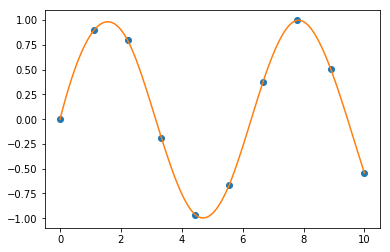

In [545]:
x = np.linspace(0, 10, 10)
y = np.sin(x)
spl = splrep(x, y)
x2 = np.linspace(0, 10, 200)
y2 = splev(x2, spl)
plt.plot(x, y, 'o', x2, y2)
plt.show()

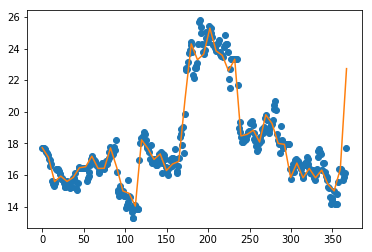

In [546]:
x = range(0,367)
y = days_df['Day Avg Vol']
spl = splrep(x, y)
x2 = np.linspace(0, 367)
y2 = splev(x2, spl)
plt.plot(x, y, 'o', x2, y2)
plt.show()

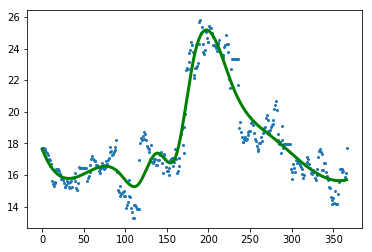

In [606]:
# creates a univariate spline using scipy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html
# updated version is LSQUnivariateSpline

from scipy.interpolate import UnivariateSpline

spl = UnivariateSpline(Xdata, ydata)
plt.plot(Xdata, ydata, 'o', ms=2)
plt.plot(Xdata, spl(Xdata), 'g', lw=3)


In [548]:
print(spl.derivative())

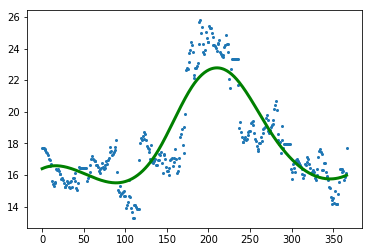

In [623]:
# k is the number of terms in the polynomials that comprise the spline, 3 = cubic
# s is a smoothing factor

spl = UnivariateSpline(Xdata, ydata, k=3, s=800)

plt.plot(Xdata, ydata, 'o', ms=2)
plt.plot(Xdata, spl(Xdata), 'g', lw=3)

In [550]:
# creastes function for first derivative of spl spline implemented above

derivative = spl.derivative()

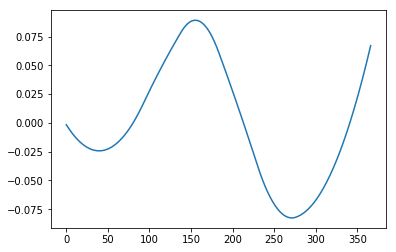

In [551]:
plt.plot(Xdata, derivative(Xdata))

C:\Users\Trader\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'1st Derivative')

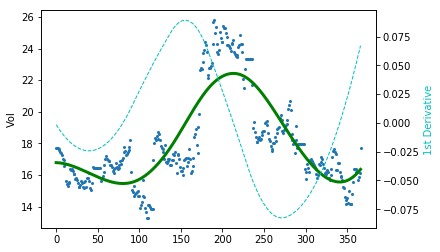

In [572]:
# creates a plot with two axis, 111 indicates relative position and size of each plot
# 211 can be used to create stacked plots

fig = plt.figure()
plt.plot(Xdata, ydata, 'o', ms=2)
ax1 = fig.add_subplot(1,1,1)
ax1.plot(Xdata, spl(Xdata), 'g', lw=3)
ax1.set_ylabel('Vol')

ax2 = ax1.twinx()
ax2.plot(Xdata, derivative(Xdata), 'c--', lw=1)
ax2.set_ylabel('1st Derivative', color='c')

In [624]:
print(spl.derivatives(350))

[1.57553467e+01 4.43950725e-03 1.18979956e-03 1.17931538e-06]


In [553]:
from scipy.interpolate import LSQUnivariateSpline

The section below uses the LSQ univariate spline which allows user to specify where knots should be

In [604]:
# LSQspl = LSQUnivariateSpline(range(0,367), ydata, [90,180,270])

In [605]:
spl.get_knots()

array([  0.,  92., 138., 183., 229., 275., 366.])

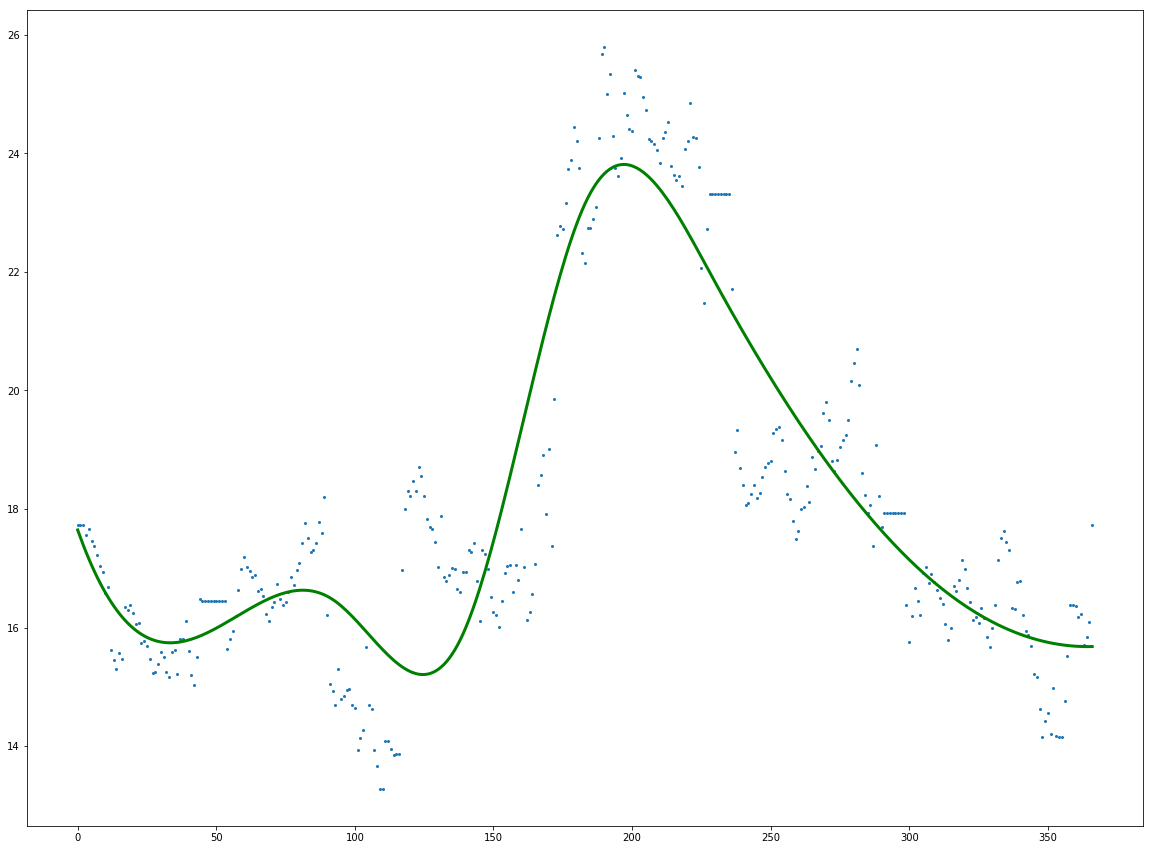

In [647]:
# t array can be changed to shift the inflection points between each section of the spline
# how can we write a loop to fit these and find the best fit spline?
# look at ARIMA / GARCH with Python model 

x = range(0,367)
y = ydata
t = [92,138,183,229,312]
spline_LSQ = LSQUnivariateSpline(x, y, t, k=3)
plt.figure(figsize=(20,15))
plt.plot(x, y, 'o', ms=2)
plt.plot(x, spline_LSQ(x), 'g-', lw=3)
plt.show()

In [600]:
print(spline_LSQ.derivatives(0))
print(spline_LSQ.derivatives(366))

[ 1.76976267e+01 -1.39157516e-01  5.95754225e-03 -1.05134505e-04]
[1.57228283e+01 6.64467948e-03 9.88846494e-04 5.96361477e-06]


In [597]:
LSQspl.get_coeffs()

array([15.50959502, 19.36239784,  9.84037072, 25.29802402, 19.36548163,
       14.58182779, 16.05602739])

In [648]:
# def error function for spline vs. data 
# error should be a function of knot coordinates and historical data
# fill pandas data frame with know coordinates and error and rank by error
# find a monte carlo method